## Introduction

 In this notebook, we aim to predict the academic risk of students in higher education using various machine learning techniques. The dataset includes information known at the time of student enrollment, covering academic path, demographics, and socio-economic factors.

### Dataset Characteristics
- **Tabular**
- **Subject Area**: Social Science
- **Associated Tasks**: Classification
- **Feature Type**: Real, Categorical, Integer
- **# Features**: 36

### Dataset Information
The dataset was created to contribute to reducing academic dropout and failure in higher education by identifying students at risk early in their academic path. This allows for timely intervention strategies to support these students.

### Summary of Techniques and Findings

#### Successful Techniques
1. **AutoML**: Trained a LightGBM model with a set of hyperparameters based on findings using AutoML before any feature engineering.
2. **One-Hot Encoding**: Applied one-hot encoding to categorical features.
3. **Polynomial Features**: Generated polynomial features to capture interactions between numerical features.
4. **Label Encoding**: Encoded the target variable using label encoding.
5. **SMOTE**: Applied Synthetic Minority Over-sampling Technique (SMOTE) to balance the target variable classes.
6. **Creating Age Groups**: Binning age into specific groups improved the model.
7. **Admission Grade Binning**: Binning the admission grade into quartiles improved the model.

#### Unsuccessful Techniques
1. **Min-Max Scaling**: Applying Min-Max scaling to numerical features did not improve the model.
2. **Standard Scaling**: Standard scaling of numerical features did not yield better results.
3. **Robust Scaling**: Robust scaling was also not effective.
4. **PCA**: Applying Principal Component Analysis did not improve model performance.
5. **Additional Polynomial Degrees**: Generating polynomial features beyond degree 2 did not yield better results.
6. **Additional Age Groups**: Creating more specific age group bins beyond those used did not improve the model.
7. **Additional Admission Grade Binning**: Binning the admission grade into more categories beyond the quartiles did not improve the model.
8. **Different Encoding Techniques**: Using different encoding techniques like target encoding and ordinal encoding did not yield better results.
9. **Outlier Removal**: Attempting to remove outliers did not improve model performance.
10. **Feature Normalization**: Normalizing the numerical features did not improve model performance.
11. **Feature Selection by Threshold**: Removing features based on a certain importance threshold did not yield better results.

### Observations

AutoML built the best model from the start despite trying all types of hyperparameter tuning. The inicial EDA didn't give much insight on how to improve the features because despite any relations established, the best improvement to the data came in oversampling due to imbalance in the target. SMOTE and polynomial features gave about 0.04 improvements on the accuracy score, which was considerable in this scope. After polynomials, the data had 370 but after extensive testing, their didn't seem to be any improvement in narrowing down the number. Even low importance features seemed to affect the efficiency of the model, probably due to the skewed distribution in many of the features; where most of the features would be clustered around a certain range with a small but considerable amount of outliers that couldn't be ignored because they had a heavy relation to the target. Maybe a further visualization of those cluster would be interesting. Examples of these features are: Marriage, Age, International, etc...


In [1]:
%%capture
# Cell 1: Install Necessary Packages
!pip install flaml
!pip install imbalanced-learn
!pip install scikit-optimize
!pip install category_encoders


In [2]:
# Cell 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, OneHotEncoder
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Ignore warnings
warnings.filterwarnings('ignore')


In [4]:
# Cell 3: Load Data
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

# Removing white spaces from feature names
train.columns = [x.replace(' ', '_') for x in train.columns]
test.columns = [x.replace(' ', '_') for x in test.columns]


## Correlation Check

We check the correlation between features to understand relationships between variables better.

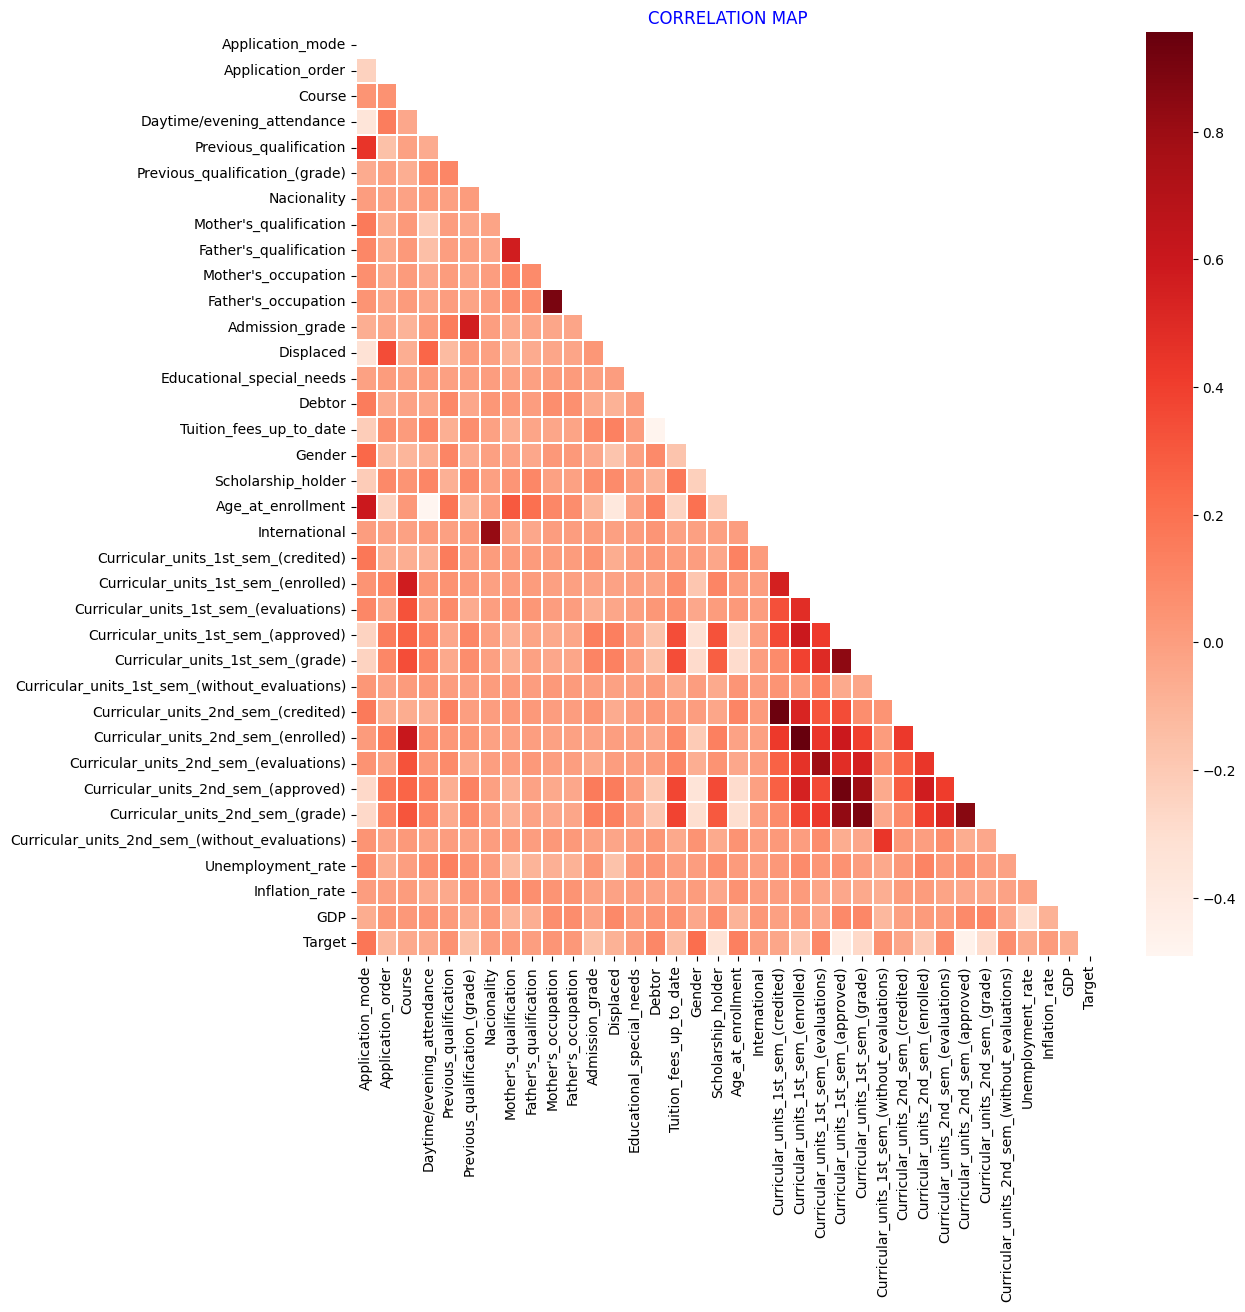

In [5]:
# Cell 4: Correlation Check
X = train[train.columns[1:-1]]
X['Target'] = [1 if x == 'Graduate' else 2 if x == 'Dropout' else 3 for x in train['Target']]
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plotting correlation heatmap
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask, cmap='Reds', linewidth=0.1)
plt.title('CORRELATION MAP', color='blue', fontsize=12)
plt.show()


## Distribution Plots

We visualize the distribution of key features to understand the data better.

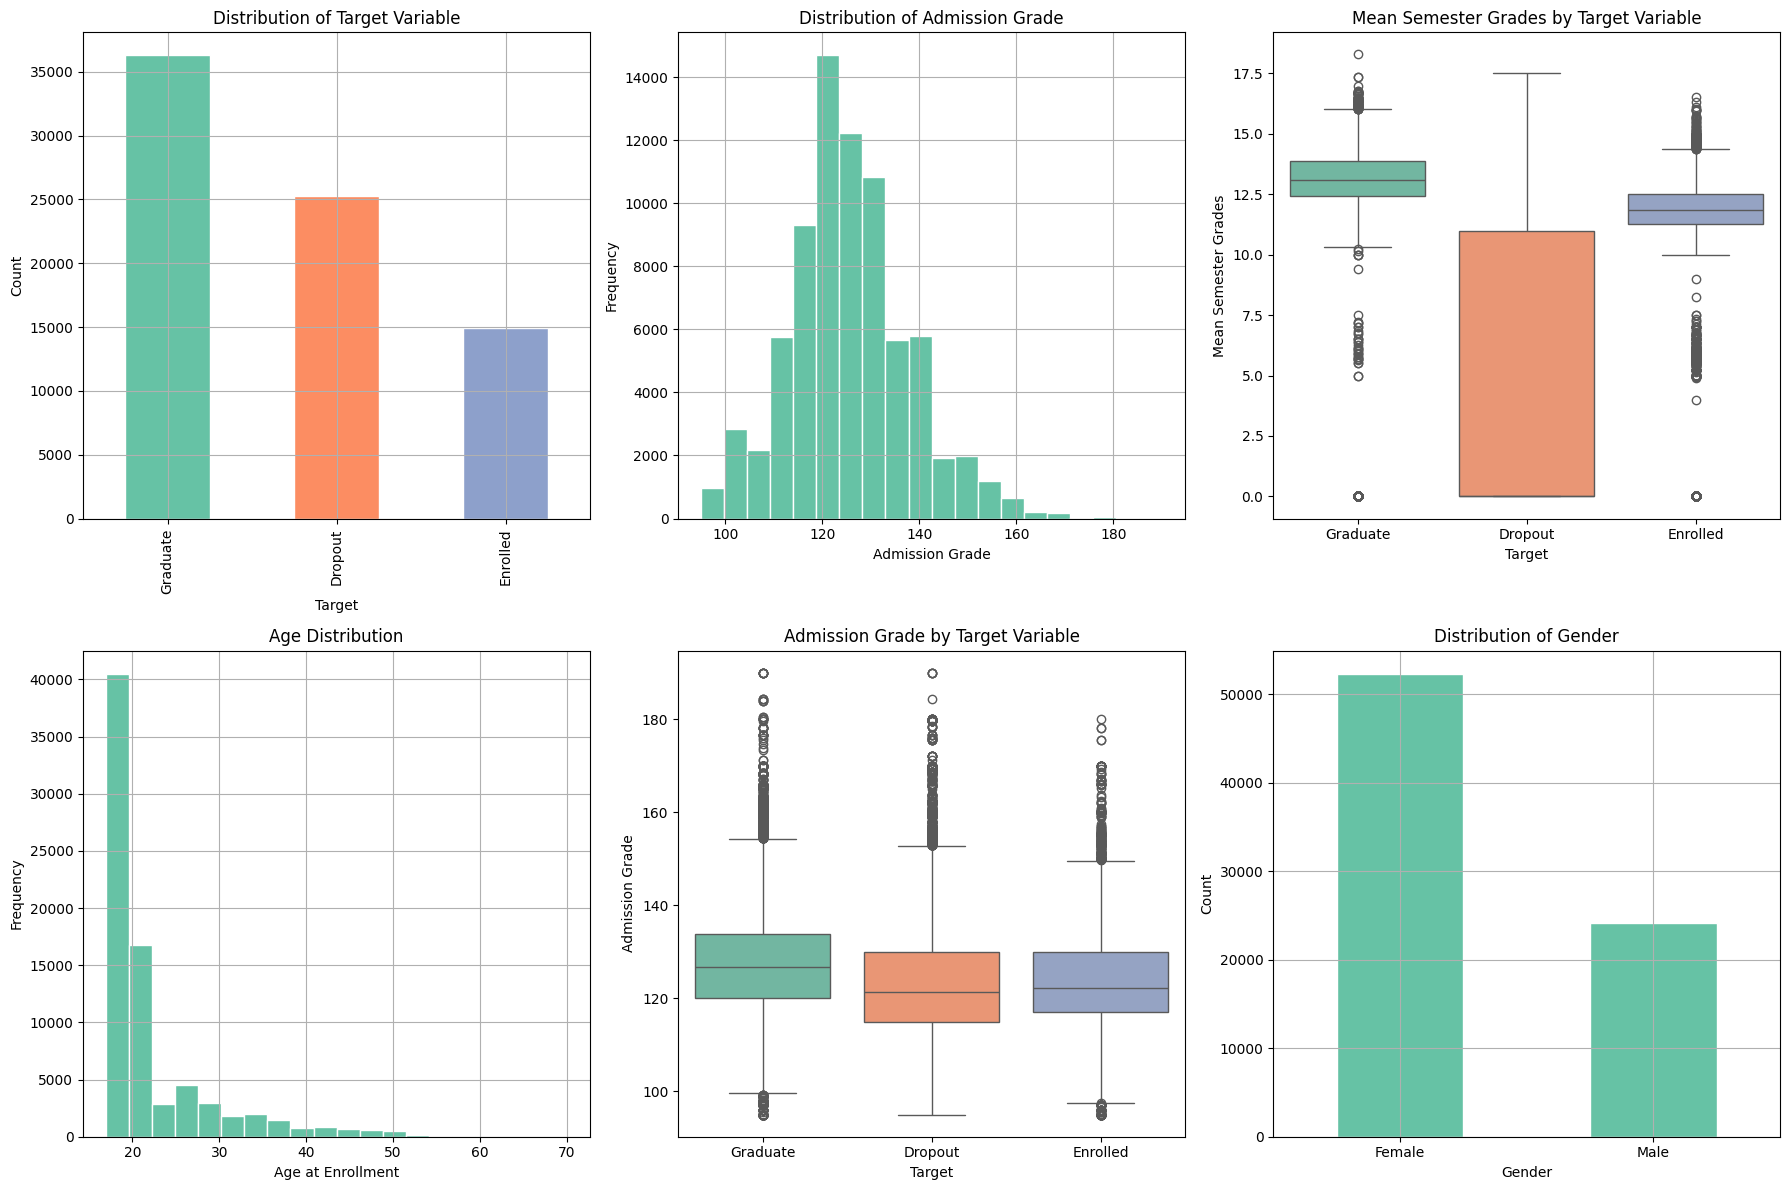

In [6]:
# Cell 5: Distribution Plots
palette = sns.color_palette("Set2", 3)
target_palette = {'Graduate': palette[0], 'Dropout': palette[1], 'Enrolled': palette[2]}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sns.set_style("whitegrid")

train['Target'].value_counts().plot(kind='bar', ax=axes[0, 0], title='Distribution of Target Variable', color=[target_palette['Graduate'], target_palette['Dropout'], target_palette['Enrolled']])
axes[0, 0].set_xlabel('Target')
axes[0, 0].set_ylabel('Count')

train['Admission_grade'].plot(kind='hist', bins=20, ax=axes[0, 1], title='Distribution of Admission Grade', color=palette[0])
axes[0, 1].set_xlabel('Admission Grade')
axes[0, 1].set_ylabel('Frequency')

train['Mean_Semester_Grade'] = (train['Curricular_units_1st_sem_(grade)'] + train['Curricular_units_2nd_sem_(grade)']) / 2
sns.boxplot(x='Target', y='Mean_Semester_Grade', data=train, ax=axes[0, 2], palette=[target_palette['Graduate'], target_palette['Dropout'], target_palette['Enrolled']])
axes[0, 2].set_title('Mean Semester Grades by Target Variable')
axes[0, 2].set_xlabel('Target')
axes[0, 2].set_ylabel('Mean Semester Grades')

train['Age_at_enrollment'].plot(kind='hist', bins=20, ax=axes[1, 0], title='Age Distribution', color=palette[0])
axes[1, 0].set_xlabel('Age at Enrollment')
axes[1, 0].set_ylabel('Frequency')

sns.boxplot(x='Target', y='Admission_grade', data=train, ax=axes[1, 1], palette=[target_palette['Graduate'], target_palette['Dropout'], target_palette['Enrolled']])
axes[1, 1].set_title('Admission Grade by Target Variable')
axes[1, 1].set_xlabel('Target')
axes[1, 1].set_ylabel('Admission Grade')

train['Gender'].value_counts().plot(kind='bar', ax=axes[1, 2], title='Distribution of Gender', color=palette[0])
axes[1, 2].set_xlabel('Gender')
axes[1, 2].set_xticklabels(['Female', 'Male'], rotation=0)
axes[1, 2].set_ylabel('Count')

plt.tight_layout()
plt.show()

train = train.drop('Mean_Semester_Grade', axis=1)


## Gender vs. Target Distribution

Analyze the distribution of target variable across genders.


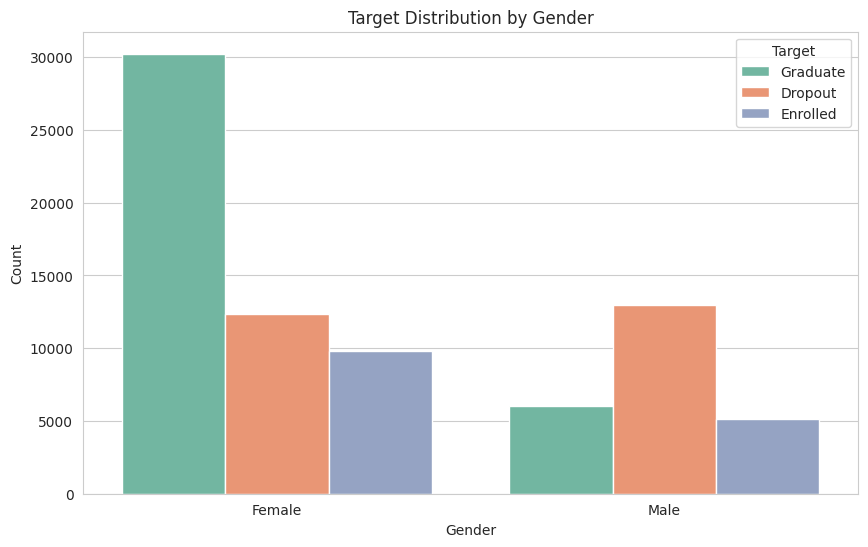

In [7]:
# Cell 6: Gender vs. Target Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Target', data=train, palette=[target_palette['Graduate'], target_palette['Dropout'], target_palette['Enrolled']])
plt.title('Target Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Target')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()


In [8]:
# Cell 7: Chi-Square Test
contingency_table = pd.crosstab(train['Gender'], train['Target'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f'Chi-Square Test:\nChi2: {chi2}\np-value: {p}')


Chi-Square Test:
Chi2: 8342.754349629984
p-value: 0.0


## Age Group and Scholarship Analysis

Analyze the distribution of target variable across different age groups and scholarship holders.


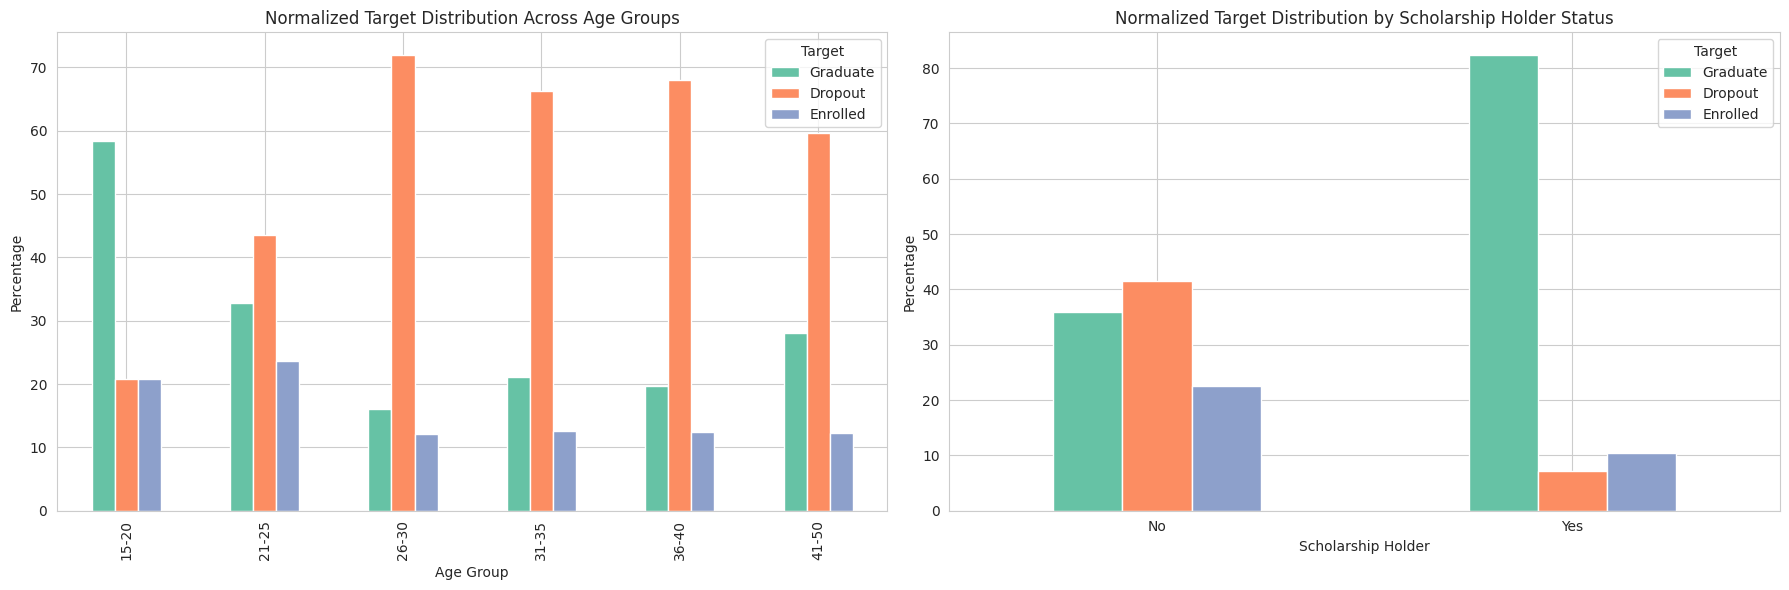

In [9]:
# Cell 8: Age Group and Scholarship Analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
train['Age_Group'] = pd.cut(train['Age_at_enrollment'], bins=[15, 20, 25, 30, 35, 40, 50], labels=['15-20', '21-25', '26-30', '31-35', '36-40', '41-50'])

age_group_distribution = train.groupby('Age_Group')['Target'].value_counts(normalize=True).unstack().fillna(0) * 100
age_group_distribution = age_group_distribution[['Graduate', 'Dropout', 'Enrolled']]
age_group_distribution.plot(kind='bar', ax=axes[0], color=[target_palette['Graduate'], target_palette['Dropout'], target_palette['Enrolled']])
axes[0].set_title('Normalized Target Distribution Across Age Groups')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Percentage')
axes[0].legend(title='Target')

scholarship_distribution = train.groupby('Scholarship_holder')['Target'].value_counts(normalize=True).unstack().fillna(0) * 100
scholarship_distribution = scholarship_distribution[['Graduate', 'Dropout', 'Enrolled']]
scholarship_distribution.plot(kind='bar', ax=axes[1], color=[target_palette['Graduate'], target_palette['Dropout'], target_palette['Enrolled']])
axes[1].set_title('Normalized Target Distribution by Scholarship Holder Status')
axes[1].set_xlabel('Scholarship Holder')
axes[1].set_ylabel('Percentage')
axes[1].set_xticklabels(['No', 'Yes'], rotation=0)
axes[1].legend(title='Target')

plt.tight_layout()
plt.show()

train = train.drop(['Age_Group'], axis=1)


## Feature Engineering

Perform feature engineering by creating interaction features and polynomial features, and apply one-hot encoding to categorical variables.


In [10]:
# Cell 9: Feature Engineering
train['Age_Group'] = pd.cut(train['Age_at_enrollment'], bins=[15, 20, 25, 30, 35, 40, 50], labels=['15-20', '21-25', '26-30', '31-35', '36-40', '41-50'])
train['Admission_grade_bin'] = pd.qcut(train['Admission_grade'], q=4, labels=False)

# One-Hot Encoding categorical features
categorical_features = [
    'Marital_status', 'Application_mode', 'Application_order', 'Course',
    'Daytime/evening_attendance', 'Previous_qualification', 'Nacionality',
    "Mother's_qualification", "Father's_qualification", "Mother's_occupation", "Father's_occupation",
    'Age_Group'
]

# Apply One-Hot Encoding
encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
encoded_cats = encoder.fit_transform(train[categorical_features])
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features), index=train.index)

# Drop original categorical columns and add the encoded ones
train = train.drop(columns=categorical_features)
train = pd.concat([train, encoded_cats_df], axis=1)

# Generating Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
numerical_features = [
    'Previous_qualification_(grade)', 'Admission_grade', 'Age_at_enrollment',
    'Curricular_units_1st_sem_(credited)', 'Curricular_units_1st_sem_(enrolled)',
    'Curricular_units_1st_sem_(evaluations)', 'Curricular_units_1st_sem_(approved)',
    'Curricular_units_1st_sem_(grade)', 'Curricular_units_1st_sem_(without_evaluations)',
    'Curricular_units_2nd_sem_(credited)', 'Curricular_units_2nd_sem_(enrolled)',
    'Curricular_units_2nd_sem_(evaluations)', 'Curricular_units_2nd_sem_(approved)',
    'Curricular_units_2nd_sem_(grade)', 'Curricular_units_2nd_sem_(without_evaluations)',
    'Unemployment_rate', 'Inflation_rate', 'GDP'
]

# Select numerical features for polynomial transformation
X_numerical = train[numerical_features]
X_poly = poly.fit_transform(X_numerical)

# Combine polynomial features with original features
poly_features = poly.get_feature_names_out(X_numerical.columns)
train_poly_df = pd.DataFrame(X_poly, columns=poly_features, index=train.index)

# Combine with original features while avoiding duplicates
train = train.drop(columns=numerical_features)
train = pd.concat([train, train_poly_df], axis=1)

# Removing white spaces from feature names because of polynomial features
train.columns = [x.replace(' ', '_') for x in train.columns]
test.columns = [x.replace(' ', '_') for x in test.columns]


## Separate Features and Target

Separate the features and target variable for model training.


In [11]:
# Cell 10: Separate Features and Target
X = train.drop('Target', axis=1)
y = train['Target']

# Label Encode Target Variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


## Apply SMOTE to Balance the Target Variable

Use SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes in the target variable.


In [12]:
# Cell 11: Apply SMOTE to Balance the Target Variable
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2)


## Train LightGBM Model with Regularization

Train a LightGBM model with regularization.


In [13]:
# Cell 12: Train LightGBM Model with Regularization
lgb_params = {
    'colsample_bytree': 0.7464704583099742,
    'learning_rate': 0.12421185223120967,
    'max_bin': 251,
    'min_child_samples': 7,
    'n_estimators': 199,
    'num_leaves': 750,
    'reg_alpha': 0.001297151743034896,
    'reg_lambda': 0.0028201449346997825,
    'force_col_wise': True,
    'verbosity': -1  # Suppress warnings
}

# Initialize and train the model with early stopping
lgbm_model = lgb.LGBMClassifier(**lgb_params)
lgbm_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])


LGBMClassifier(colsample_bytree=0.7464704583099742, force_col_wise=True,
               learning_rate=0.12421185223120967, max_bin=251,
               min_child_samples=7, n_estimators=199, num_leaves=750,
               reg_alpha=0.001297151743034896, reg_lambda=0.0028201449346997825,
               verbosity=-1)

## Model Evaluation on Validation Set

Evaluate the trained model on the validation set.


In [14]:
# Cell 13: Model Evaluation on Validation Set
y_pred = lgbm_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy on Validation Data: {accuracy:.4f}\n')


Accuracy on Validation Data: 0.8748



## Preprocess Test Data

Apply the same preprocessing steps to the test data as applied to the train data.


In [15]:
# Cell 14: Preprocess Test Data
# Apply the same preprocessing steps to the test data as applied to the train data
test['Age_Group'] = pd.cut(test['Age_at_enrollment'], bins=[15, 20, 25, 30, 35, 40, 50], labels=['15-20', '21-25', '26-30', '31-35', '36-40', '41-50'])
test['Admission_grade_bin'] = pd.qcut(test['Admission_grade'], q=4, labels=False)

# Apply One-Hot Encoding to categorical features in test data
encoded_test_cats = encoder.transform(test[categorical_features])
encoded_test_cats_df = pd.DataFrame(encoded_test_cats, columns=encoder.get_feature_names_out(categorical_features), index=test.index)

# Drop original categorical columns and add the encoded ones in test data
test = test.drop(columns=categorical_features)
test = pd.concat([test, encoded_test_cats_df], axis=1)

# Generate Polynomial Features for test data
X_test_numerical = test[numerical_features]
X_test_poly = poly.transform(X_test_numerical)
test_poly_df = pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out(X_test_numerical.columns), index=test.index)

# Combine polynomial features with original features in test data
test = test.drop(columns=numerical_features)
test = pd.concat([test, test_poly_df], axis=1)


## Make Predictions on Test Data

Use the trained model to make predictions on the test data and create the submission file.


In [16]:
# Cell 15: Make Predictions on Test Data
test_predictions = lgbm_model.predict(test)

# Decode the predicted labels to original categories
test_predictions_labels = label_encoder.inverse_transform(test_predictions)

# Create the submission DataFrame
submission_df = pd.DataFrame({'id': test.index, 'Target': test_predictions_labels})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")


Submission file created successfully!
